# Replication of "Malignant and Benign Breast Cancer Classification using Machine Learning Algorithms" study
Author: Ivan Klabučar - 0036513702

### Features which were removed from the dataset

In the study, I am not 100% sure because of clumsy wording, but I think they removed the ’fractal_dimension_mean’, ’texture_se’, and ’symmetry_se’ features on account of them not being highly correlated to the target variable. It is not explicitly stated in the study but I am also removing the ID column, even though they computed its correlation to the target variable for some reason.
<br>
TLDR:<br>
- fractal_dimension_mean (fractal_dimension1)
- texture_se (texture2)
- symmetry_se (symmetry2)
- ID

### Data scaling
Even though the different features are on completely different scales, no mention of normalization is found in the study. For the purposes of replication we will not perform any scaling as well even though this would be highly recommended for some models.

### Algorithms tested in study

- Logistic Regression
- Support Vector Machine (SVM)
- Random Forest
- Naive Bayes
- Decision Tree
- K-Nearest Neighbors (KNN)

In the study, no mention of the exact configuration of hyperparameters of the models can be found. We will therefore use reasonable defaults from the sklearn library.

## Methodology

They split the original dataset into 25% testing and 75% training data sets randomly. They do not give percise specification of the split so we cannot recreate it. We will do our own random data split.

The models were first trained/fit on training data and then tested on test data.

For reproducibility reasons we will use random_state=42 where applicable.

## Evaluation metrics

For evaluation of models simple Accuracy was used. 

## Replication

### Imports

In [123]:
# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Data
from sklearn.model_selection import train_test_split
from ucimlrepo import fetch_ucirepo 
import pandas as pd
import numpy as np
import requests
import io

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier

#Evaluation
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score


# Omogucujemo prikaz vise podataka
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

Utility functions:

In [127]:
# Utility function for plotting the confusion matrix
def plot_CFM(cfm, title):
    sns.heatmap(cfm, 
                annot=True, 
                fmt='d', 
                cmap="Blues",
                cbar=False,
                xticklabels= ['Predicted Negative', 'Predicted Positive'],
                yticklabels=['True Negative', 'True Positive'])
    plt.xlabel('Predicted')
    plt.ylabel('Ground Truth')
    plt.title(title)
    plt.show()

# Utility function for plotting the ROC curve 'Receiver Operating Characteristic'
def plot_roc(fpr, tpr, roc_auc, title):
    plt.title(title)
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.4f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

Getting the dataset:

In [111]:
url = "https://archive.ics.uci.edu/static/public/17/data.csv"
x = requests.get(url=url, verify=False).content 
df = pd.read_csv(io.StringIO(x.decode('utf8')))

/Users/klabs/miniconda3/envs/py39/lib/python3.9/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host 'archive.ics.uci.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


In [112]:
df.head()

,ID,radius1,texture1,perimeter1,area1,smoothness1,compactness1,concavity1,concave_points1,symmetry1,fractal_dimension1,radius2,texture2,perimeter2,area2,smoothness2,compactness2,concavity2,concave_points2,symmetry2,fractal_dimension2,radius3,texture3,perimeter3,area3,smoothness3,compactness3,concavity3,concave_points3,symmetry3,fractal_dimension3,Diagnosis
0,842302,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,M
1,842517,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,M
2,84300903,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,M
3,84348301,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,M
4,84358402,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,M


We need to remove:
- fractal_dimension_mean (fractal_dimension1)
- texture_se (texture2)
- symmetry_se (symmetry2)
- ID

from the dataset:

In [113]:
df.drop(columns=['fractal_dimension1', 'texture2', 'symmetry2', 'ID'], inplace=True)

The target variable needs to be numeric, so we will apply the mapping B -> 0, M -> 1. In other words we consider 'malign' to be the positive class.

In [114]:
df.Diagnosis.value_counts()

Diagnosis
B    357
M    212
Name: count, dtype: int64

In [115]:
df['Diagnosis'] = df['Diagnosis'].map({'B': 0, 'M': 1})

In [116]:
df.Diagnosis.value_counts()

Diagnosis
0    357
1    212
Name: count, dtype: int64

We need to split the data into testing and training data with a 0.25 <-> 0.75 random split.

In [117]:
feature_names = list(df.columns)
feature_names.remove('Diagnosis')

y = df.Diagnosis.values
X = df[feature_names].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [118]:
print(f"X_train.shape: {X_train.shape}")
print(f"X_test.shape: {X_test.shape}")
print(f"y_train.shape: {y_train.shape}")
print(f"y_test.shape: {y_test.shape}")

X_train.shape: (426, 27)
X_test.shape: (143, 27)
y_train.shape: (426,)
y_test.shape: (143,)


We will evaluate every model defined in the MODELS_TO_EVAL dictionary. Evaluation will be comprised of calculating every metric defined in the MODEL_EVALUATION_RESULT dict and plotting the model's Confusion matrix as well as the ROC curve.

In [128]:
MODELS_TO_EVAL = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'K-Nearest Neighbors (KNN, K=5)': KNeighborsClassifier(), #n_neighbors=5 is the default 
    'Decision Tree': tree.DecisionTreeClassifier(random_state=42),
    'Naive Bayes': GaussianNB(),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Support Vector Machine (SVM)': SVC(probability=True, random_state=42)
}

MODEL_EVALUATION_RESULT = {
    'Model':                 None,
    'Training Accuracy (%)': None,
    'Testing Accuracy (%)':  None,
    'ROC_AUC':               None,
    'Precision (%)':         None,
    'Recall (%)':            None
}
results = []

Running the experiemnt:

/Users/klabs/miniconda3/envs/py39/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


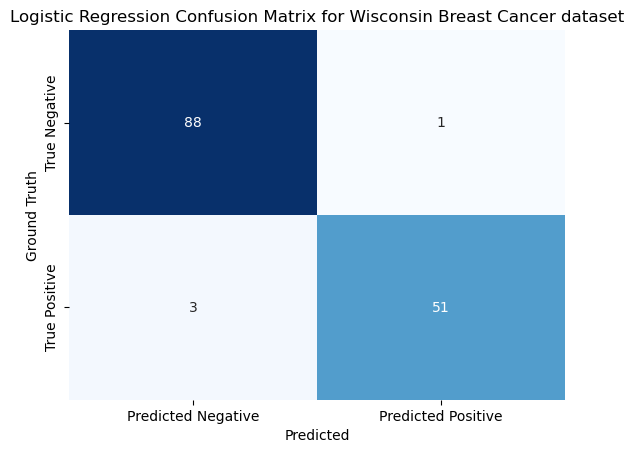

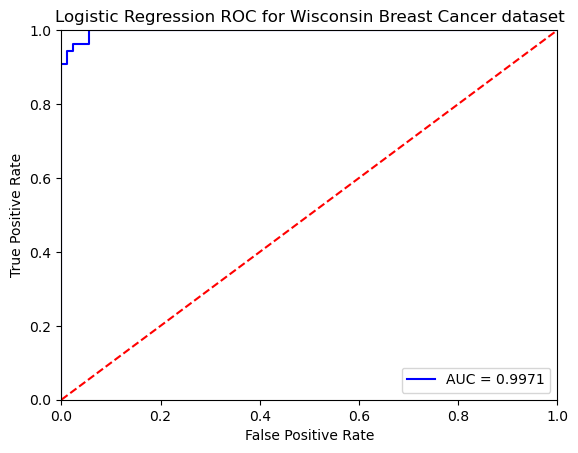

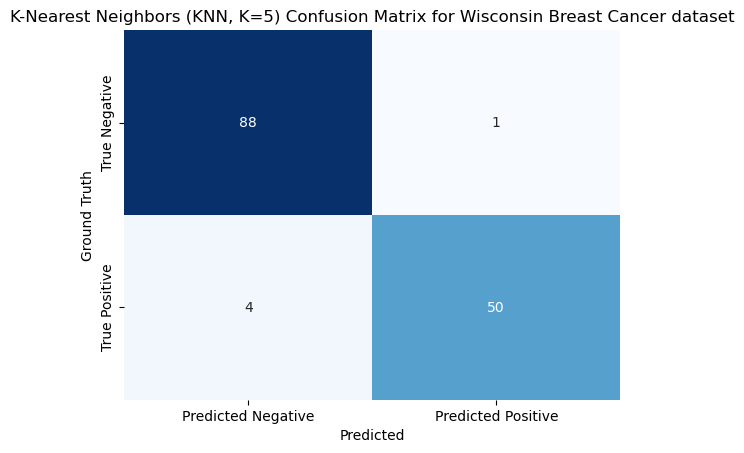

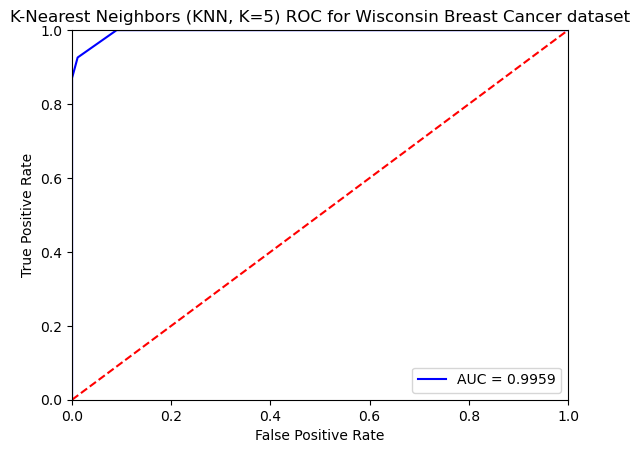

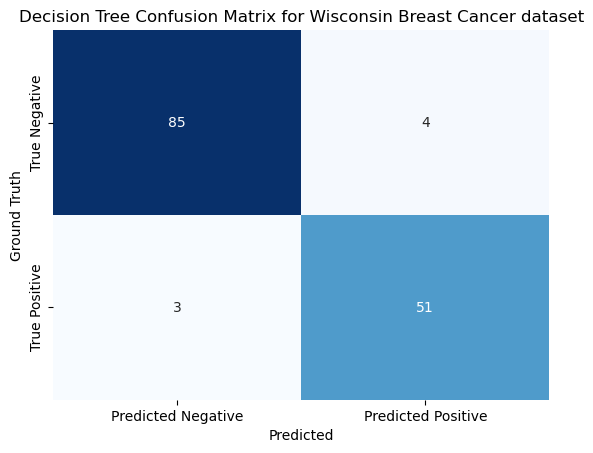

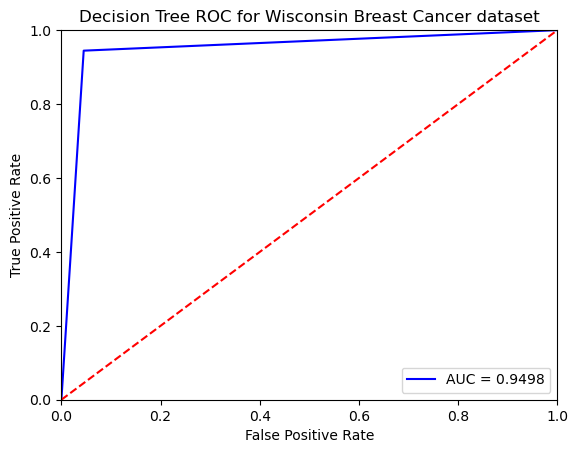

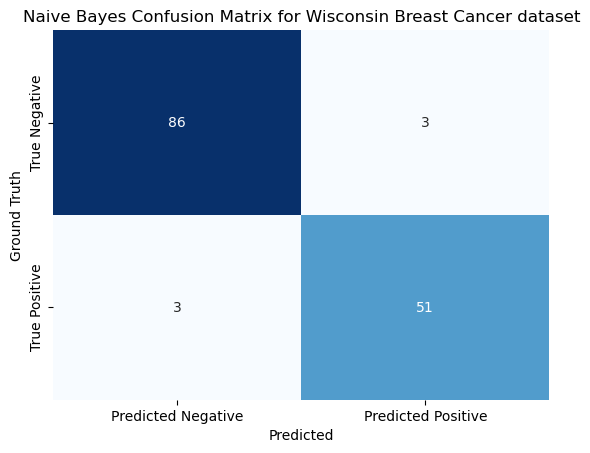

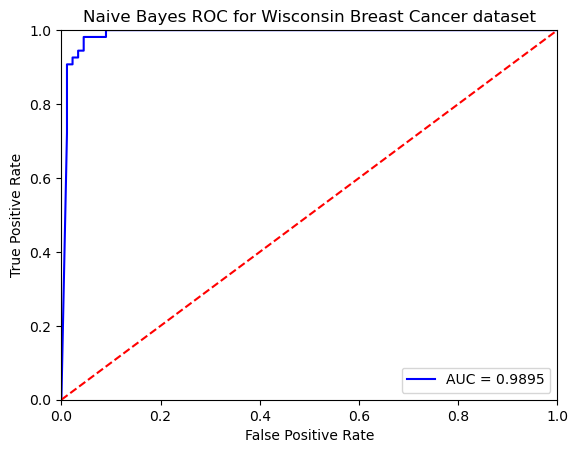

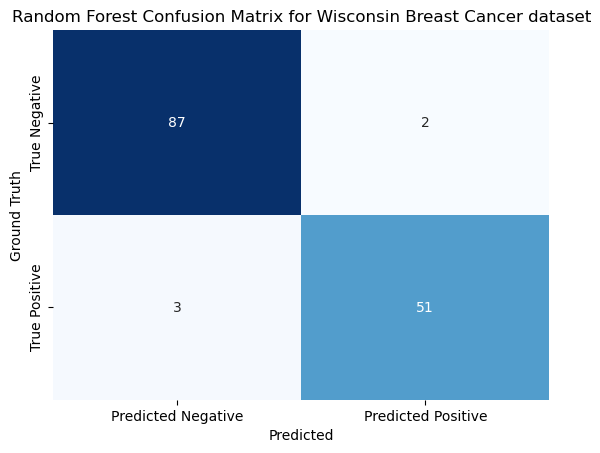

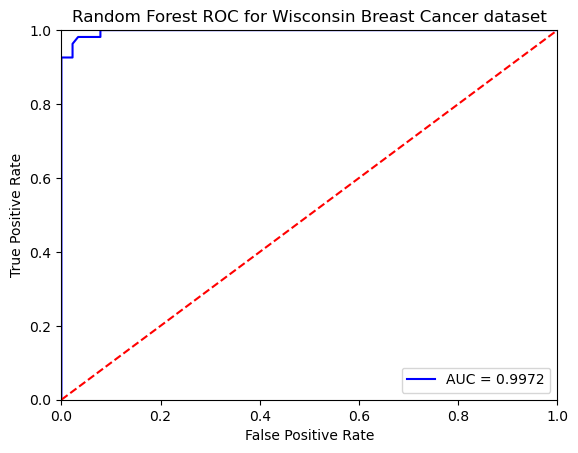

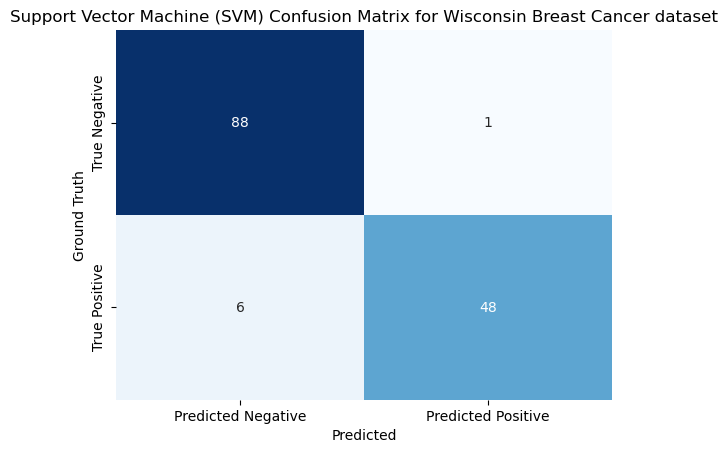

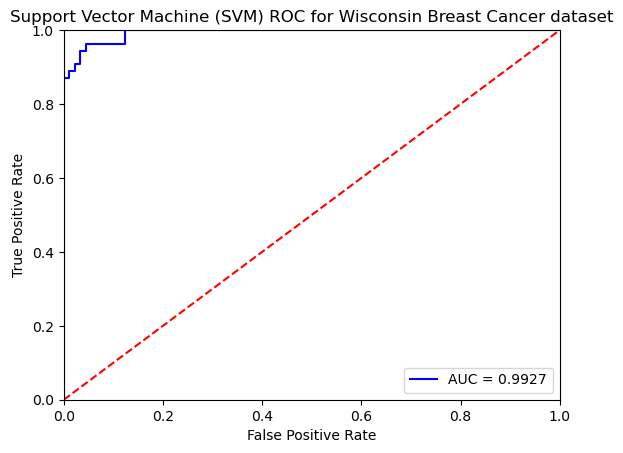

In [129]:
for model_name in MODELS_TO_EVAL:
    classifier = MODELS_TO_EVAL[model_name].fit(X_train, y_train)
    
    train_predictions = classifier.predict(X_train)
    test_predictions = classifier.predict(X_test)
    malign_probabilities = classifier.predict_proba(X_test)[:, 1]
    fpr, tpr, threshold = roc_curve(y_test, malign_probabilities)
    roc_auc = auc(fpr, tpr)

    curr_result = MODEL_EVALUATION_RESULT.copy()
    curr_result['Model'] = model_name
    curr_result['Training Accuracy (%)'] = round(accuracy_score(y_train, train_predictions) * 100, 1)
    curr_result['Testing Accuracy (%)'] = round(accuracy_score(y_test, test_predictions) * 100, 1)
    curr_result['ROC_AUC'] = round(roc_auc_score(y_test, malign_probabilities), 5)
    curr_result['Precision (%)'] = round(precision_score(y_test, test_predictions) * 100, 1)
    curr_result['Recall (%)'] = round(recall_score(y_test, test_predictions) * 100, 1)
    results.append(curr_result)

    # Plotting CFM and ROC
    CFM = confusion_matrix(y_test, test_predictions)
    plot_CFM(CFM, f'{model_name} Confusion Matrix for Wisconsin Breast Cancer dataset')
    plot_roc(fpr, tpr, roc_auc, f'{model_name} ROC for Wisconsin Breast Cancer dataset')

results = pd.DataFrame(results)

Results:

In [121]:
results

,Model,Training Accuracy (%),Testing Accuracy (%),ROC_AUC,Precision (%),Recall (%)
0,Logistic Regression,93.9,97.2,0.99709,98.1,94.4
1,"K-Nearest Neighbors (KNN, K=5)",93.4,96.5,0.99594,98.0,92.6
2,Decision Tree,100.0,95.1,0.94975,92.7,94.4
3,Naive Bayes,93.7,95.8,0.98949,94.4,94.4
4,Random Forest,100.0,96.5,0.99719,96.2,94.4
5,Support Vector Machine (SVM),91.1,95.1,0.99272,98.0,88.9


# Conclusion
While the replicated results are in the same ballpark as the original study they are not identical. While in the original study the Random Forest and SVM algorithms outperformed others on the test set, the result of our experiemnt shows Logistic Regression performed the best on the test set with 97.2% accuracy.

The differences are due to:
- The original study did not disclose the exact training / test split. The algorithms in this replication study were trained and tested on slightlz different data. In such circumstances it is expected for the end result to differ somewhat.
- The original study did not disclose the exact configuration of the hyperparameters used for alogirthm fitting/training. We are therefore not certain we tested the exact same versions of the algorithms used in the original study.